<h1><center>ICT for Smart Mobility</center></h1>

<center><font size="5">Exercise – Transport modelling - 2nd part </font></center>
<center><font size="5">Trip generation model of demand with KDE </font></center>



In this second part of the practical activity, you will create a demand model for trip generation in continuous space.

With KDE, you do NOT need to choose an appropriate zoning system.  The demand model should generalize and you will perform calibration and validation process.

In [30]:
#!pip install folium geojsoncontour

In [31]:
import pandas as pd
df=pd.read_csv("Amsterdam_dataset.csv")

In [32]:
df

,Unnamed: 0,start_longitude,start_latitude,end_longitude,end_latitude,start_longitude_utm,start_latitude_utm,end_longitude_utm,end_latitude_utm,hour,daytype
0,7860,4.87345,52.33396,4.82726,52.35371,119982.797780,483016.349361,116851.530361,485237.087955,23,weekday
1,7872,4.90472,52.37038,4.91088,52.34494,122141.094886,487053.891014,122542.006910,484220.588956,23,weekday
2,7887,4.92591,52.36526,4.92612,52.35110,123580.569820,486474.827223,123584.850648,484899.252532,23,weekday
3,7854,4.87818,52.39087,4.88443,52.37641,120349.660072,489346.036596,120763.943156,487734.199761,23,weekday
4,7861,4.93046,52.33535,4.90276,52.35757,123869.504307,483144.993367,121998.086446,485629.503238,23,weekday
...,...,...,...,...,...,...,...,...,...,...,...
3649,575334,4.88705,52.36311,4.84528,52.38648,120932.135664,486253.167987,118106.464532,488873.832576,23,weekday
3650,575332,4.86997,52.36838,4.85935,52.36600,119772.934718,486847.688238,119047.722853,486588.098133,23,weekday
3651,575343,4.88375,52.36534,4.93667,52.37119,120709.083198,486502.840335,124317.543982,487130.008302,23,weekday
3652,575329,4.84560,52.38111,4.86470,52.36538,118123.783770,488276.187663,119411.610806,486516.474729,23,weekday


##
## STEP A – KDE for trip generation

    • Implement a simple KDE with Gaussian Kernel and arbitrary h or use the KernelDensity model from sklearn  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html
    • Fit this model to the data
    • Obtain the model for P(O) and P(D)


In this solution I will use the already implemented model

* from sklearn.neighbors import KernelDensity


In [33]:
from sklearn.neighbors import KernelDensity
import numpy as np
import geopandas as gpd

 - Obtain the model for P(O) - origin trips

In [34]:
X_origin=df[["start_longitude","start_latitude"]]

### Note

EPSG:4326 uses latitude and longitude as coordinates, which are in degrees. The issue is that 1 degree of latitude does not correspond to 1 degree of longitude in terms of distance on the ground, except at the equator. The distance represented by a degree of longitude varies with latitude, being largest at the equator and decreasing to zero at the poles.

Using KDE with a single bandwidth (h) means to treat latitude and longitude as if they were in the same unit of measure, which is not the case. This can lead to distorted density estimates because the smoothing effect of the kernel will not be uniform across the two dimensions.

In the remainder of this solution, we are fitting the distribution purely on the coordinates in EPSG:4326. Since we are using a KDE model with a single smoothing parameter h, the two dimensions should be in the same unit of measure. Here we are working with latitude and longitude in Amsterdam, where a movemement of a car of 0.01 degrees in latitude does not correspond to a movement of 0.01 degrees in longitude. Hence, applying the method to UTM coordinates coverted to meters, will solve this issue and would lead to more correct results.

For problems for which different dimensions have different meaning, other more complex KDE models exists, where you can define a matrix H of smoothing parameters (many h), one for each dimension and one for each pairs of dimensions. These are called multivariate KDE.
Reference: https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation

We fit a KDE model with gaussian kernel and bandwidth equal to 0.05

In [35]:
# Convert to UTM (Zone 31N for Amsterdam)
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df['start_longitude'], 
                                                   df['start_latitude']),
                       crs='EPSG:4326')
gdf_utm = gdf.to_crs('EPSG:32631')

# Extract coordinates in meters
X_origin_converted = np.column_stack([gdf_utm.geometry.x, gdf_utm.geometry.y])

In [36]:
X_origin_converted

array([[ 627648.35784314, 5799835.48278162],
       [ 629672.10376678, 5803941.51722236],
       [ 631129.73166864, 5803410.30502887],
       ...,
       [ 628259.210836  , 5803343.60584465],
       [ 625617.15555204, 5805030.50734976],
       [ 632554.44782525, 5801937.0788794 ]], shape=(3654, 2))

In [37]:
# KDE in original coordinates
kde_origin = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X_origin) # h is 0.05 degrees

# KDE in converted coordinates
kde_converted = KernelDensity(kernel='gaussian', bandwidth=500).fit(X_origin_converted)    # h is 500 meters

Now we have a model (kde_origin) that is a probability distribution over 2 dimensions (longitude and latitude). 

We can sample from our models. Let's sample 4 new origin points (couples of coordinates)

In [38]:
# Sample new points of origin coordinates
new_samples_origin=kde_origin.sample(4)
print(f"New samples origin:\n{new_samples_origin}\n")

# Sample new points of converted coordinates
new_samples_converted=kde_converted.sample(4)
print(f"New samples converted:\n{new_samples_converted}")

New samples origin:
[[ 4.87596887 52.27697693]
 [ 4.90353809 52.33076206]
 [ 4.85064618 52.30032869]
 [ 4.92423374 52.35295364]]

New samples converted:
[[ 626117.05021612 5805431.9021275 ]
 [ 628335.22747888 5803369.8113236 ]
 [ 629521.45288323 5802291.9655475 ]
 [ 625551.04652422 5807082.83100566]]


 - Obtain the model for P(D) - destination trips

In [39]:
X_destination=df[["end_longitude","end_latitude"]]

In [40]:
# Convert to UTM (Zone 31N for Amsterdam)
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df['end_longitude'], 
                                                   df['end_latitude']),
                       crs='EPSG:4326')
gdf_utm = gdf.to_crs('EPSG:32631')

# Extract coordinates in meters
X_destination_converted = np.column_stack([gdf_utm.geometry.x, gdf_utm.geometry.y])

In [41]:
# KDE in original coordinates
kde_destination = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X_destination)   # h is 0.05 degrees

# KDE in converted coordinates
kde_destination_converted = KernelDensity(kernel='gaussian', bandwidth=500).fit(X_destination_converted)    # h is 500 meters

    • Show the distributions P(O) and P(D) of the trip generation model on a map

We can measure the loglikelihood of the sample, i.e., their probability in the obtained density 

Let's first measure the loglikelihood of the first 3 samples in our data

In [42]:
log_density = kde_origin.score_samples(X_origin[:3])
log_density

array([3.73152427, 3.9133054 , 3.76248838])

In [43]:
#Here I am finding the min logitude, max longitude, min latitude and max latitude observed as origin/destination
#EXACTLY AS IN THE PREVIOUS SET OF EXERCISES

import numpy as np

# Find min and max coordinates for longitude and latitude (original coordinates)
min_lon=min(df["start_longitude"].min(),df["end_longitude"].min())
max_lon=max(df["start_longitude"].max(),df["end_longitude"].max())
min_lat=min(df["start_latitude"].min(),df["end_latitude"].min())
max_lat=max(df["start_latitude"].max(),df["end_latitude"].max())

# Find min and max coordinates for x and y (converted coordinates)
min_x=min(X_origin_converted[:,0].min(),X_destination_converted[:,0].min())
max_x=max(X_origin_converted[:,0].max(),X_destination_converted[:,0].max())
min_y=min(X_origin_converted[:,1].min(),X_destination_converted[:,1].min())
max_y=max(X_origin_converted[:,1].max(),X_destination_converted[:,1].max())

Now create a grid of points to evaluate the density on

In [44]:
#grid size in degrees: the smaller it is, the larger the number of points in the grid
grid_size=0.001 # each cell is 0.001 x 0.001 degrees
# x coordinates of the grid cells
xgrid = np.arange(min_lon, max_lon, grid_size)
# y coordinates of the grid cells
ygrid = np.arange(min_lat, max_lat, grid_size)
X, Y = np.meshgrid(xgrid, ygrid)
xy = np.vstack([X.ravel(), Y.ravel()]).T

# grid size in converted coordinates: the smaller it is, the larger the number of points in the grid
grid_size_converted=100 # each cell is 100 x 100 meters
# x coordinates of the grid cells
xgrid_converted = np.arange(min_x, max_x, grid_size_converted)
# y coordinates of the grid cells
ygrid_converted = np.arange(min_y, max_y, grid_size_converted)
X_converted, Y_converted = np.meshgrid(xgrid_converted, ygrid_converted)
xy_converted = np.vstack([X_converted.ravel(), Y_converted.ravel()]).T

In [47]:
print(f"xy: {xy}\n")
print(f"xy_converted: {xy_converted}")

xy: [[ 4.8178 52.3025]
 [ 4.8188 52.3025]
 [ 4.8198 52.3025]
 ...
 [ 5.0108 52.4145]
 [ 5.0118 52.4145]
 [ 5.0128 52.4145]]

xy_converted: [[ 623718.76298727 5796337.18877403]
 [ 623818.76298727 5796337.18877403]
 [ 623918.76298727 5796337.18877403]
 ...
 [ 636918.76298727 5808837.18877403]
 [ 637018.76298727 5808837.18877403]
 [ 637118.76298727 5808837.18877403]]


xy contains now all the points in the 2D grid for which we want to estimate the density

In [48]:
# kde_origin.score_samples(xy) returns the log density estimates for each point in xy (pairs of lon, lat)
# np.exp(...) converts log density to density

# estimate the density for original coordinates
Z = np.exp(kde_origin.score_samples(xy))
Z = Z.reshape(X.shape)

# estimate the density in converted coordinates
Z_converted = np.exp(kde_converted.score_samples(xy_converted))
Z_converted = Z_converted.reshape(X_converted.shape)

/home/cavallinux/Backup/Magistrale/ICT4SmartMobility/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


Now create a contour plot given the density Z over the grid of points XY

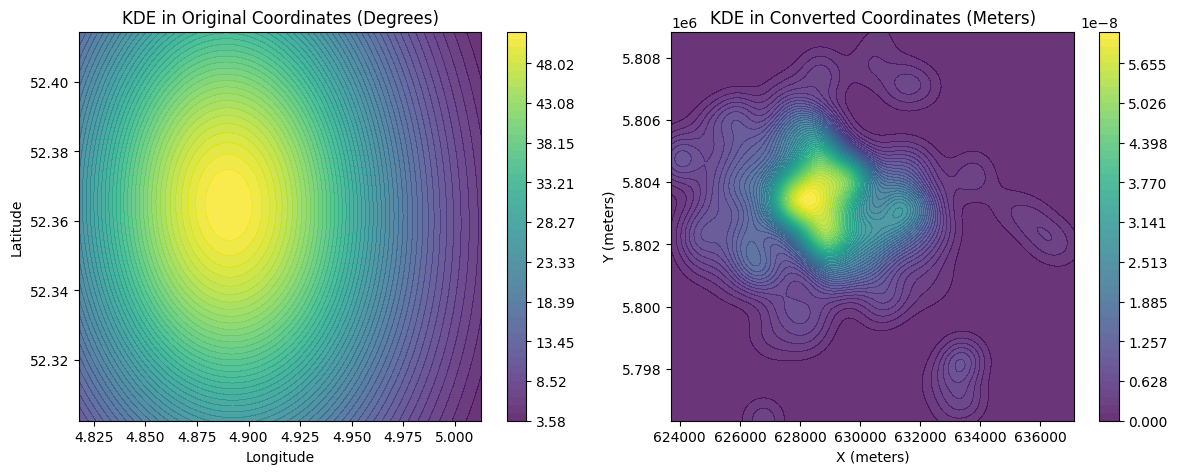

In [50]:
import matplotlib.pyplot as plt

# plot with subfigures original and converted coordinates
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# plot contours of the density for original coordinates
levels = np.linspace(Z.min(), Z.max(), 50)
contourf=plt.contourf(X, Y, Z, levels=levels,alpha=0.8)
plt.colorbar(contourf)
plt.title("KDE in Original Coordinates (Degrees)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(1, 2, 2)
# plot contours of the density for converted coordinates
levels_converted = np.linspace(Z_converted.min(), Z_converted.max(), 50)
contourf_converted=plt.contourf(X_converted, Y_converted, Z_converted, levels=levels_converted,alpha=0.8)
plt.colorbar(contourf_converted)
plt.title("KDE in Converted Coordinates (Meters)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

plt.tight_layout()
plt.show()


Let's now plot the same contour plot over a map of Amsterdam

In [52]:
import folium
import geojsoncontour

In [53]:
# Convert matplotlib contourf
geojson=geojsoncontour.contourf_to_geojson(contourf=contourf)

m=folium.Map(location=[(min_lat+max_lat)/2,(min_lon+max_lon)/2],zoom_start=12)
folium.GeoJson(geojson,\
              style_function=lambda x:{ \
                                      'opacity': 0.5,\
                                      'color': x['properties']['stroke'],\
                                      },\
              ).add_to(m)
m

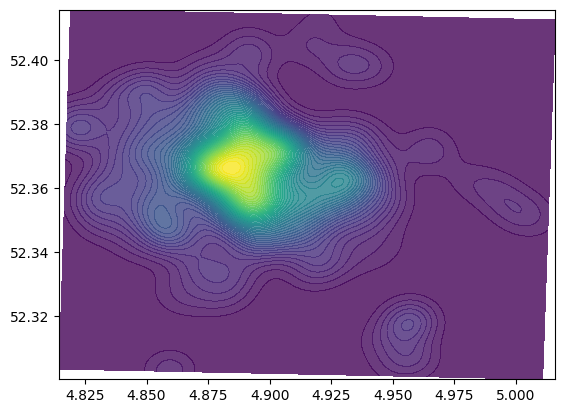

In [57]:
# show converted coordinates density
# First, convert the UTM grid back to lat/lon for visualization
from shapely.geometry import Point

# Create a GeoDataFrame with the UTM grid points
points_utm = [Point(x, y) for x, y in xy_converted]
gdf_grid = gpd.GeoDataFrame(geometry=points_utm, crs='EPSG:32631')

# Convert to lat/lon
gdf_grid_latlon = gdf_grid.to_crs('EPSG:4326')

# Extract lat/lon coordinates
xy_latlon = np.array([[point.x, point.y] for point in gdf_grid_latlon.geometry])

# Reshape for contour plotting
X_latlon = xy_latlon[:, 0].reshape(X_converted.shape)
Y_latlon = xy_latlon[:, 1].reshape(X_converted.shape)

# Create contour plot in lat/lon coordinates with converted KDE density
levels_converted = np.linspace(Z_converted.min(), Z_converted.max(), 50)
contourf_converted_latlon = plt.contourf(X_latlon, Y_latlon, Z_converted, levels=levels_converted, alpha=0.8)

# Convert to GeoJSON
geojson_converted = geojsoncontour.contourf_to_geojson(contourf=contourf_converted_latlon)

# Create Folium map
m_converted = folium.Map(location=[(min_lat+max_lat)/2, (min_lon+max_lon)/2], zoom_start=12)

folium.GeoJson(geojson_converted,
              style_function=lambda x: {
                  'opacity': 0.5,
                  'color': x['properties']['stroke'],
              }).add_to(m_converted)

m_converted

Repeat the same for DESTINATION density

/home/cavallinux/Backup/Magistrale/ICT4SmartMobility/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


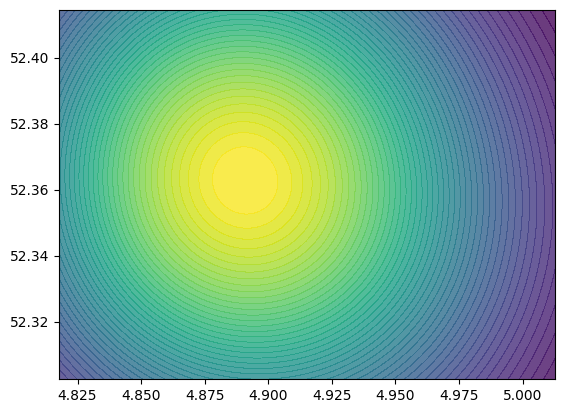

In [ ]:
#Estimate the density
Z = np.exp(kde_destination.score_samples(xy))
Z = Z.reshape(X.shape)

levels = np.linspace(Z.min(), Z.max(), 50)
contourf=plt.contourf(X, Y, Z, levels=levels,alpha=0.8)

# Convert matplotlib contourf
geojson=geojsoncontour.contourf_to_geojson(contourf=contourf)

In [34]:
m=folium.Map(location=[(min_lat+max_lat)/2,(min_lon+max_lon)/2],zoom_start=12)
folium.GeoJson(geojson,\
              style_function=lambda x:{ \
                                      'opacity': 0.5,\
                                      'color': x['properties']['stroke'],\
                                      },\
              ).add_to(m)
m

##
## STEP B – Calibration of trip generation – finding bandwidth h
          
    • Evaluate the total log likelihood metric to be maximized: 1/N sum_(samples s) log(P(s)). You can also use score_samples of KernelDensity class of sklearn


Let's now measure the total likelihood of all the samples in our data.

Let's do it in two equivalent ways:

In [19]:
#option 1
#total average log likelhiood
tot_score_origin_1=1/len(X_origin) *kde_origin.score(X_origin)
tot_score_origin_1

np.float64(3.7545165520600743)

In [20]:
#option 2
#total average log likelhiood
tot_score_origin_2=1/len(X_origin) *kde_origin.score_samples(X_origin).sum()
tot_score_origin_2

np.float64(3.7545165520600743)

Let's compute the total average loglikelihood also for the destination model (only with option 1):

In [21]:
#total average log likelhiood
tot_score_destination=1/len(X_destination) *kde_destination.score(X_destination)
tot_score_destination

np.float64(3.498448788089132)

    • Calibrate the bandwidth h in order to maximize loglikelihood (go back to STEP A and recompute the trip generation model with different h)
    • What is a good value for h? What is the corresponding loglikelihood?

In [22]:
#define a list of bandwidth h to try - we define them logarithmically spaced 
#this is equal to h_list=[0.00001,0.0001, 0.001, 0.01, 0.1,1]
h_list= np.logspace(-5, 0, num=6)

#define lists to save results of loglikelihood
logLikelihoodOrigin_list=[]
logLikelihoodDestination_list=[]

for h in h_list:
    kde_origin = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_origin)
    tot_score_origin=1/len(X_origin) *kde_origin.score(X_origin)
    logLikelihoodOrigin_list.append(tot_score_origin)
    
    kde_destination = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_destination)
    tot_score_destination=1/len(X_destination) *kde_destination.score(X_destination)
    logLikelihoodDestination_list.append(tot_score_destination)

In [23]:
logLikelihoodOrigin_list

[np.float64(13.019597331109312),
 np.float64(8.863476846413526),
 np.float64(5.767891251001125),
 np.float64(4.895674250561456),
 np.float64(2.649651139279914),
 np.float64(-1.839137966918694)]

In [24]:
logLikelihoodDestination_list

[np.float64(13.043072011526657),
 np.float64(8.952850722954087),
 np.float64(5.753914993410924),
 np.float64(4.507312098343849),
 np.float64(2.5547915734995),
 np.float64(-1.8402486813953938)]

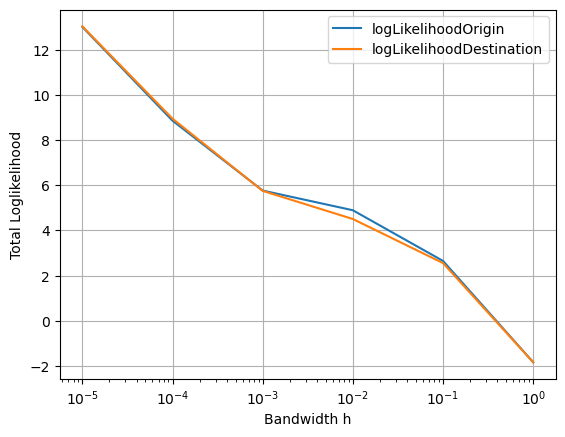

In [25]:
import matplotlib.pyplot as plt
plt.plot(h_list,logLikelihoodOrigin_list, label='logLikelihoodOrigin' )
plt.plot(h_list,logLikelihoodDestination_list, label='logLikelihoodDestination' )
plt.xlabel("Bandwidth h")
plt.ylabel("Total Loglikelihood")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

By considering all the data: the smaller the bandwidth, the best is the fit! This is true, because we are just overfitting the data

##
## STEP C – Validation of trip generation – finding bandwidth h

    • Divide the sample dataset into random training and validation samples and fit the KDE models (origin and destination) to the training data



In [26]:
from sklearn.model_selection import train_test_split
X_train_origin, X_validation_origin = train_test_split(X_origin, test_size=0.33, shuffle=True)
X_train_destination, X_validation_destination = train_test_split(X_destination, test_size=0.33, shuffle=True)

In [27]:
kde_train_origin = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_origin)
kde_train_destination = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_destination)

    • Evaluate the total log likelihood of the training and validation


In [28]:
#Loglikelihood for origin train
tot_score_train_origin=1/len(X_train_origin) *kde_train_origin.score(X_train_origin)
tot_score_train_origin


np.float64(-1.8391441355088451)

In [29]:
#Loglikelihood for destination train
tot_score_train_destination=1/len(X_train_destination) *kde_train_destination.score(X_train_destination)
tot_score_train_destination

np.float64(-1.8402890737562076)

    • Calibrate the bandwidth h as in STEP B, but now on the TRAINING in order to maximize loglikelihood on the VALIDATION 
    • What are the differences with respect to step B?


In [30]:
#define a list of bandwidth h to try - we define them logarithmically spaced 
#this is equal to h_list=[0.00001,0.0001, 0.001, 0.01, 0.1,1]
h_list= np.logspace(-5, 0, num=6)

#define lists to save results of loglikelihood
logLikelihoodOrigin_train_list=[]
logLikelihoodDestination_train_list=[]
model_origin_list=[] #list to save the obtained KDE models
logLikelihoodOrigin_validation_list=[]
logLikelihoodDestination_validation_list=[]
model_destination_list=[] #list to save the obtained KDE models

for h in h_list:
    
    kde_train_origin = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_origin)
    tot_score_train_origin=1/len(X_train_origin) *kde_train_origin.score(X_train_origin)
    logLikelihoodOrigin_train_list.append(tot_score_train_origin)
    tot_score_validation_origin=1/len(X_validation_origin) *kde_train_origin.score(X_validation_origin)
    logLikelihoodOrigin_validation_list.append(tot_score_validation_origin)
    model_origin_list.append(kde_train_origin)
    
    
    kde_train_destination = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_destination)
    tot_score_train_destination=1/len(X_train_destination) *kde_train_destination.score(X_train_destination)
    logLikelihoodDestination_train_list.append(tot_score_train_destination)
    tot_score_validation_destination=1/len(X_validation_destination) *kde_train_destination.score(X_validation_destination)
    logLikelihoodDestination_validation_list.append(tot_score_validation_destination)
    model_destination_list.append(kde_train_destination)


In [31]:
print(logLikelihoodOrigin_train_list)
print(logLikelihoodDestination_train_list)
print(logLikelihoodOrigin_validation_list)
print(logLikelihoodDestination_validation_list)

[np.float64(13.409292806494365), np.float64(9.16749094549474), np.float64(5.845043230361324), np.float64(4.895048313137242), np.float64(2.6491245592067636), np.float64(-1.8391441355088451)]
[np.float64(13.432012908858821), np.float64(9.236313883041818), np.float64(5.83847748919195), np.float64(4.4995682750001995), np.float64(2.551526267236343), np.float64(-1.8402890737562076)]
[np.float64(-3932.7246572171475), np.float64(-27.694645380713474), np.float64(5.395149839496352), np.float64(4.89784885548276), np.float64(2.6499177259610223), np.float64(-1.8391350423594017)]
[np.float64(-4197.9120461602815), np.float64(-30.467188342907097), np.float64(5.349004594405218), np.float64(4.517032069412124), np.float64(2.5568642777426516), np.float64(-1.840227983675982)]


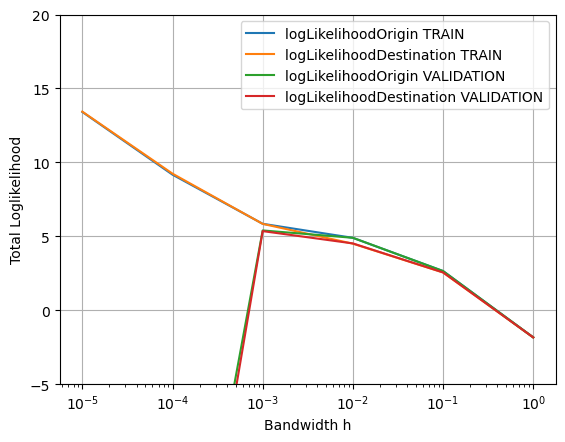

In [33]:
import matplotlib.pyplot as plt
plt.plot(h_list,logLikelihoodOrigin_train_list, label='logLikelihoodOrigin TRAIN' )
plt.plot(h_list,logLikelihoodDestination_train_list, label='logLikelihoodDestination TRAIN' )
plt.plot(h_list,logLikelihoodOrigin_validation_list, label='logLikelihoodOrigin VALIDATION' )
plt.plot(h_list,logLikelihoodDestination_validation_list, label='logLikelihoodDestination VALIDATION' )
plt.xlabel("Bandwidth h")
plt.ylabel("Total Loglikelihood")
plt.xscale("log")
plt.ylim(-5,20)
plt.legend()
plt.grid()
plt.show()

Here we can clearly see that 10^-3=0.001 represents the best value on the validation among the ones we tried. Reducing it will clearly produce under-smoothing (overfitting), while larger h will produce over-smoothing 

### Note

You could add more points to the curve to find out the exact maximum. Since the curve is convex, it is enough to search around the local maximum, for example with the bisection method

    • Show the distributions P(O) and P(D) of the trip generation model on a map

In [34]:
model_origin_list

[KernelDensity(bandwidth=np.float64(9.999999999999999e-06)),
 KernelDensity(bandwidth=np.float64(0.0001)),
 KernelDensity(bandwidth=np.float64(0.001)),
 KernelDensity(bandwidth=np.float64(0.01)),
 KernelDensity(bandwidth=np.float64(0.1)),
 KernelDensity(bandwidth=np.float64(1.0))]

/opt/conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


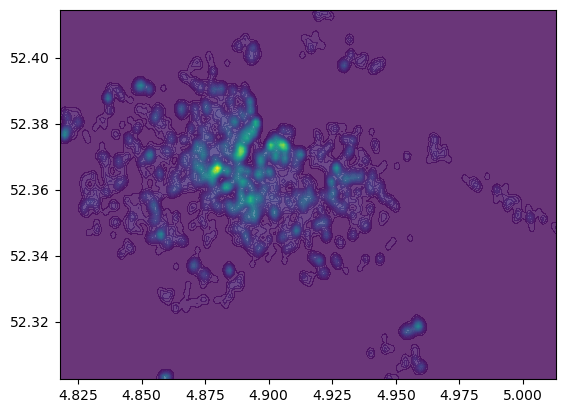

In [35]:
#Estimate the density
Z = np.exp(model_origin_list[2].score_samples(xy))
Z = Z.reshape(X.shape)

levels = np.linspace(Z.min(), Z.max(), 50)
contourf=plt.contourf(X, Y, Z, levels=levels,alpha=0.8)

# Convert matplotlib contourf
geojson=geojsoncontour.contourf_to_geojson(contourf=contourf)

m=folium.Map(location=[(min_lat+max_lat)/2,(min_lon+max_lon)/2],zoom_start=12)
folium.GeoJson(geojson,\
              style_function=lambda x:{ \
                                      'opacity': 0.5,\
                                      'color': x['properties']['stroke'],\
                                      },\
              ).add_to(m)
m

/opt/conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


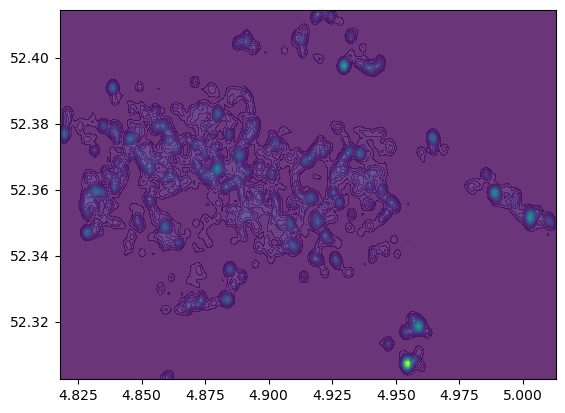

In [36]:
#Estimate the density
Z = np.exp(model_destination_list[2].score_samples(xy))
Z = Z.reshape(X.shape)

levels = np.linspace(Z.min(), Z.max(), 50)
contourf=plt.contourf(X, Y, Z, levels=levels,alpha=0.8)

# Convert matplotlib contourf
geojson=geojsoncontour.contourf_to_geojson(contourf=contourf)

m=folium.Map(location=[(min_lat+max_lat)/2,(min_lon+max_lon)/2],zoom_start=12)
folium.GeoJson(geojson,\
              style_function=lambda x:{ \
                                      'opacity': 0.5,\
                                      'color': x['properties']['stroke'],\
                                      },\
              ).add_to(m)
m